In [13]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler


import seaborn as sb
import matplotlib.pyplot as plt


<h2>Vitální charakteristiky</h2>
    <ul>
        <li>HR - Tepová frekvence (bpm)</li>
        <li>O2Sat - Saturace O2 (%)</li>
        <li>Temp - Teplota těla (° C)</li>
        <li>SBP - Systolický tlak (mmHg)</li>
        <li>MAP - Střední arteriální tlak (mmHg)</li>
        <li>DBP - Diastolický tlak (mmHg)</li>
        <li>Resp - Dechová frekvence (počet dechů za minutu)</li>
        <li>EtCO2 - Obsah CO2 ve vzduchu na konci výdechu (end-tidal CO2) (mmHg)</li>
    </ul>

<h2>Laboratorní vyšetření</h2>
    <ul>
        <li>BaseExcess - Measure of excess bicarbonate (mmol/L)</li>
        <li>HCO3 - Bikarbonáty (mmol/L)</li>
        <li>FiO2 - koncentrace O2 ve vdechovaném vzduchu (%)</li>
        <li>PaCO2 - Parciální tlak CO2 v arteriální krvi (mmHg)</li>
        <li>SaO2 - Saturace O2 v arteriální krvi (%)</li>
        <li>AST - Aspartátaminotransferáza (IU/L)</li>
        <li>BUN - Močovinový dusík v krvi (mg/dL)</li>
        <li>Alkalinephos - Alkalická fosfatáza (IU/L)</li>
        <li>Calcium - Vápník (mg/dL)</li>
        <li>Chloride - Chloridy (mmol/L)</li>
        <li>Creatinine - Kreatinin (mg/dL)</li>
        <li>Bilirubin_direct - Bilirubin přímý (mg/dL)</li>
        <li>Glucose - Glykemie (mg/dL)</li>
        <li>Lactate - Laktát (mg/dL)</li>
        <li>Magnesium - Hořčík (mmol/dL)</li>
        <li>Phosphate - Fosfát (mg/dL)</li>
        <li>Potassium - Draslík (mmol/L)</li>
        <li>Bilirubin_total - Bilirubin celkový (mg/dL)</li>
        <li>TroponinI - Troponin I (ng/mL)</li>
        <li>Hct - Hematokrit (%)</li>
        <li>Hgb - Hemoglobin (g/dL)</li>
        <li>PTT - Aktivovaný parciální tromboplastinový čas (s)</li>
        <li>WBC - Leukocyty (*10^3/µL)</li>
        <li>Fibrinogen - Fibrinogen (mg/dL)</li>
        <li>Platelets - Trombocyty (count*10^3/µL)</li>
    </ul>

<h2>Demografické charakteristiky</h2>
    <ul>
        <li>Age - Věk</li>
        <li>Gender Pohlaví: žena (0) or muž (1)</li>
        <li>Unit1 ID JIP (MICU)</li>
        <li>Unit2 ID JIP (SICU)</li>
        <li>HospAdmTime - Počet hodin mezi hospitalizaci a umístěním na JIP</li>
        <li>ICULOS - Doba strávená na JIP (hod)</li>
        <li>Stav pacienta isSepsis 0 – neseptický, 1 – septický (odhadovaná veličina)</li>
    </ul>



In [ ]:
# Sloupce vyřazené na základě statistické výzmamnosti a korelace: 'SBP', 'DBP', 'Hct', 'Age', 'Platelets', 'BUN'

# Načtení datasetu a předzpracování

In [14]:
# Cesta k tabulce s pacienty
filepath = '../dataSepsis.csv'

# Načtení celé tabulky
fullSepsis = pd.read_csv(filepath, sep=';')

# Seznam všech sloupců, které mají být odstraněny
# Sloupce jsem vybírali na základě počtu NaN, korelace a statistické významnosti

drop_list = ['Temp','EtCO2','BaseExcess','HCO3','FiO2','pH',
 'PaCO2','SaO2','AST','Alkalinephos','Chloride','Bilirubin_direct',
 'Lactate','Phosphate','Bilirubin_total','TroponinI','PTT','Fibrinogen','Unit1',
 'Unit2']

# Odstranění sloupců
relevantSepsis = fullSepsis.drop(columns=drop_list)

# Odstranění řádků, které mají polovinu a více hodnot jako NaN hodnoty
relevantSepsis = relevantSepsis.dropna(thresh=relevantSepsis.shape[1]/2)
relevantSepsis = relevantSepsis.reset_index()
relevantSepsis.drop(columns=['index'], inplace=True)

isSepsis = relevantSepsis["isSepsis"]
relevantSepsis = relevantSepsis.drop(columns="isSepsis")

df = relevantSepsis.iloc[:,:-1]
# Výpočet interquartilového rozptylu pro každý sloupce
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Stanovení horní a dolní hranice
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Nahrazení odlehlých hodnot hodnotami NaN na základě daných hranic
df_outliers_removed = df[(df >= lower_bound) & (df <= upper_bound)]

# Standardizace datasetu (dojde k převedení na array)
scaler = StandardScaler()
standardizedSepsis = scaler.fit_transform(df_outliers_removed)

# Nahrazení NaN pomocí k-nejbližších sousedů
imputer = KNNImputer(n_neighbors=100)
finalSepsis = imputer.fit_transform(standardizedSepsis)

# Zpětné převedení na dataframe
preprocessed_data = pd.DataFrame(data= finalSepsis, columns=df.columns)

# Histogram pro zobrazení zastoupení NaN v jednotlivých features

<Axes: >

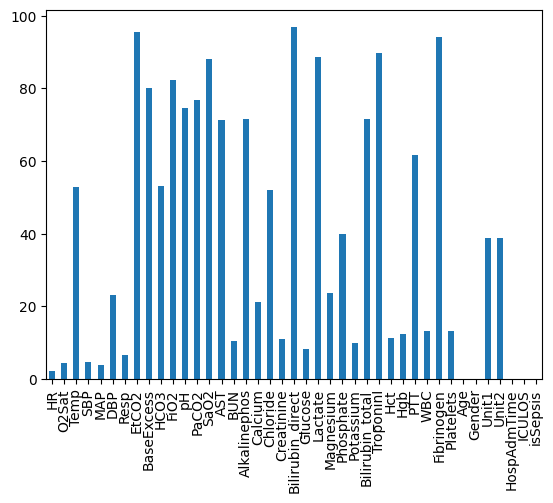

In [15]:
# Procentuální zastoupení NaN v datasetu (vztaženo na počet řádků)
NaN_percentage = (fullSepsis.isnull().sum()/fullSepsis.shape[0])*100
NaN_percentage.plot(kind="bar")


<Axes: >

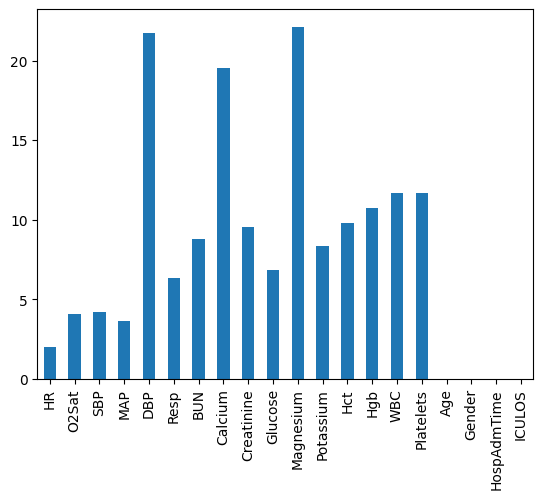

In [16]:
# Procentuální zastoupení NaN v datasetu (vztaženo na počet řádků)
NaN_percentage = (relevantSepsis.isnull().sum()/fullSepsis.shape[0])*100
NaN_percentage.plot(kind="bar")

# Heatmapa pro zobrazení korelace jednotlivých features mezi sebou 

<Axes: >

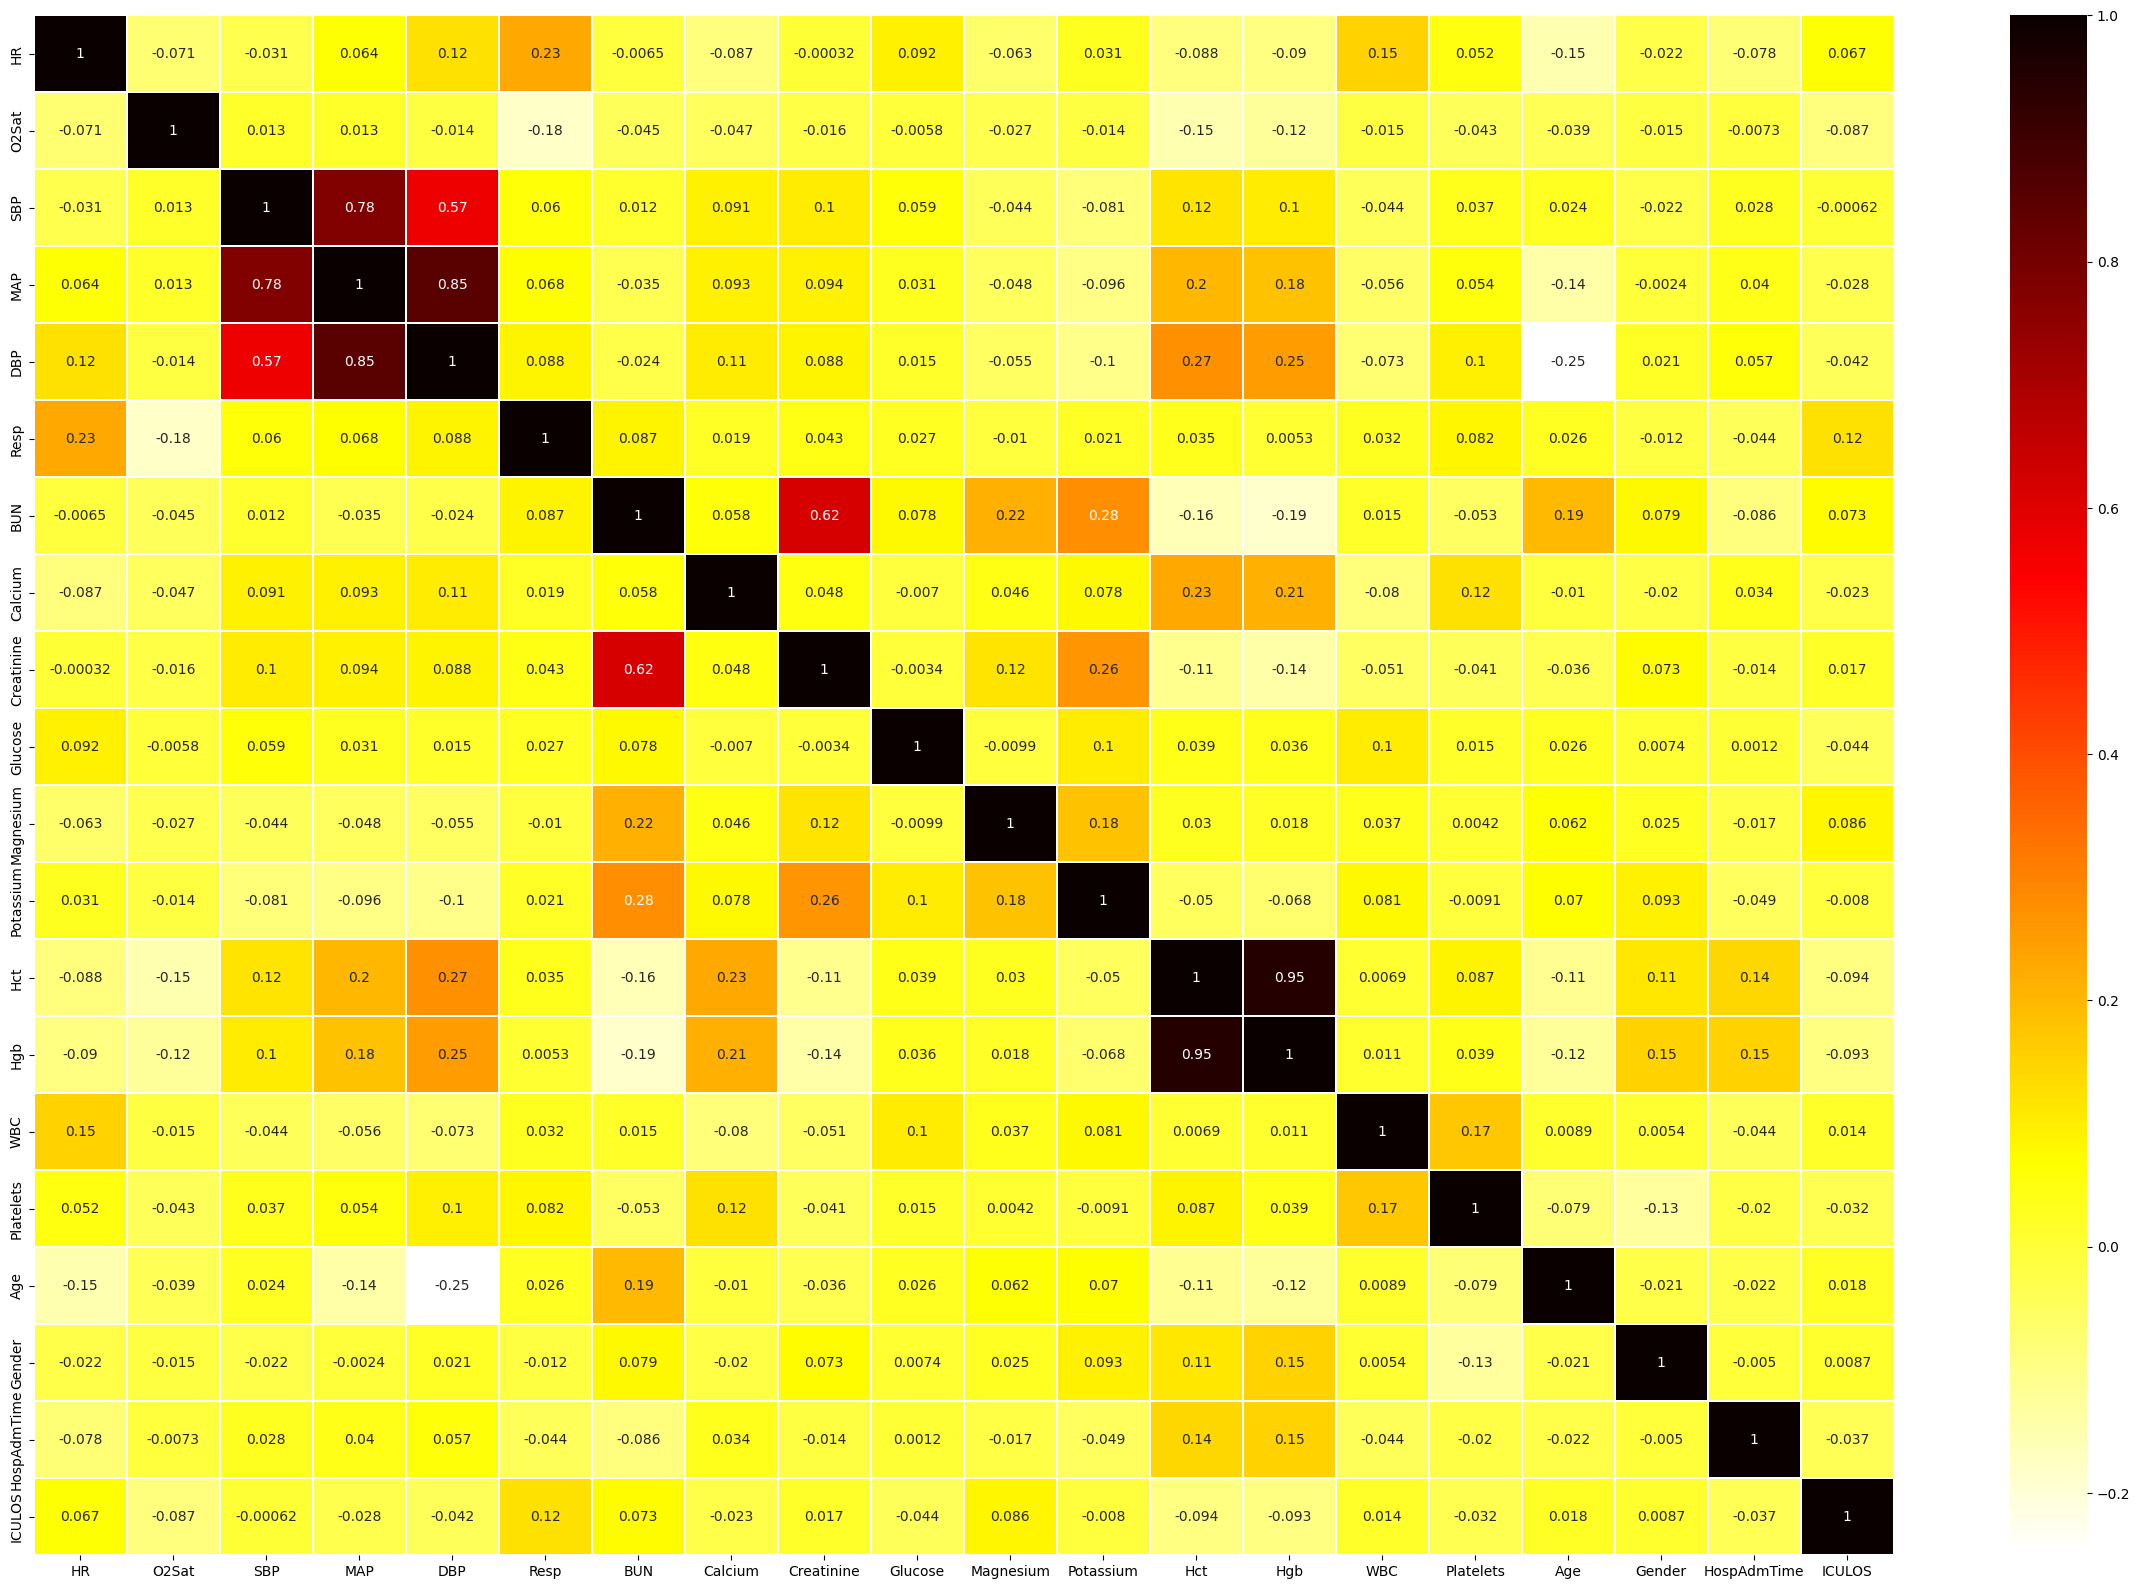

In [22]:
corr = relevantSepsis.corr(method="pearson")

fig, ax = plt.subplots(figsize=(30, 20))
sb.heatmap(corr, cmap="hot_r", annot=True, linewidths=0.3)

In [ ]:
# Vykreslení boxplotů pro sloupce pře předzpracováním
for column in relevantSepsis.columns:
    plt.figure()  # Create a new figure for each histogram
    relevantSepsis[column].plot(kind='box', title=f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
# Vykreslení boxplotů pro sloupce po předzpracování
inverted_data = scaler.inverse_transform(preprocessed_data)
inverted_data = pd.DataFrame(data= inverted_data, columns=preprocessed_data.columns)


for column in inverted_data.columns:
    plt.figure()  # Create a new figure for each histogram
    inverted_data[column].plot(kind='box', title=f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Zjištění, které příznaky nejsou významné

In [ ]:
from scipy.stats import shapiro, mannwhitneyu,ttest_ind
from collections import Counter

In [ ]:
# Funkce pro zhodnocení redundance a zjištění, zda je příznak významný či nikoliv
def Redundance(sampleSepsis0, sampleSepsis1):
    indices=[]
    indices_out = []
    for i in range(sampleSepsis0.shape[-1]):


        _, p_sepsis1 = shapiro(sampleSepsis1.iloc[:, i])
        _, p_sepsis0 = shapiro(sampleSepsis0.iloc[:, i])

        if (p_sepsis1<0.05 or p_sepsis0<0.05):
            _,p = mannwhitneyu(sampleSepsis0.iloc[:, i],sampleSepsis1.iloc[:, i])
        else:
            _,p = ttest_ind(sampleSepsis0.iloc[:, i], sampleSepsis1.iloc[:, i])

    
        if (p<0.05):
            indices.append(sampleSepsis0.iloc[:, i].name)
        else:
            indices_out.append(sampleSepsis0.iloc[:, i].name)

    return indices_out

In [ ]:
# Inicializace počítadla pro počítání výskytu příznaků
string_counter = Counter()

# Opakované volání funkce pro hodnocení redundance s náhodnými pacienty bez sepse a se sepsí 
for _ in range(1000):

    sampleSepsis1 = finalSepsis[isSepsis==1].sample(2000)
    sampleSepsis0 = finalSepsis[isSepsis==0].sample(2000)
    function_output = Redundance(sampleSepsis0, sampleSepsis1)
    string_counter.update(function_output)
    

# Vypsání příznaků, které nejsou významné, a vypsání počtu, kolikrát byly vyhodnoceny jako nevýznamné
for string, count in string_counter.items():
    print(f"{string}: {count}")